# COGS 108: Hackathon Submission #
## Crime n' Booze: Unstoppable? ##
### Jairo Chavez, Jenny Hamer, Aparna Rangamani ###

### Our question ###
What is the correlation between the crime rates and alcohol availability (evaluated by current ABC licenses) in San Diego County? Is there a relationship between the rates of particular crimes (ie. drug/alcohol violations, theft/larceny, DUI, vandalism, sex crimes, etc) and the number of establishments holding ABC licenses in the community/district?

In [1]:
% reset
% config InlineBackend.figure_format = 'retina'
% matplotlib inline

# our imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy

import statsmodels.api as sm
from scipy.stats import ttest_ind
from matplotlib import rcParams

import geocoder
import folium
from haversine import haversine

rcParams['figure.figsize'] = [15, 15]
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
sns.set(style='whitegrid', context ='paper')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [20]:
# import our incidents-100k dataset into a DataFrame
df = pd.read_csv("incidents-100k.csv")

# first remove any rows where the community is specified by NONE
# DATA CLEANING: remove rows that do not have a community specified, or community population
# print(df.shape)
df = df[df['community'] != 'NONE']
# print(df.shape)
df = df[df['comm_pop'] != 0]
# print(df.shape)

# get the community populations and plot as a bar graph to check normalization 
counts_by_community = df['community'].value_counts()
counts_by_pops = df['comm_pop'].value_counts()

comm_dict = counts_by_community.to_dict()
# print(comm_dict)

pops_dict = counts_by_pops.to_dict()
# print(pops_dict)

# plotting in seaborn
# seaborn.countplot(x='community', data=comm_pops)
sns.barplot(x=counts_by_community, y=counts_by_community.index)
sns.plt.show()

In [21]:
# bar plot of the counts by population
bargraph = sns.barplot(x=counts_by_pops.index, y=counts_by_pops)
bargraph.set_xticklabels(labels=counts_by_pops.index, rotation=55)
sns.plt.show()

In [3]:
  
# datacleaning! dictionary of Clarinova Place Codes to Full names
cpc_to_fullname = {'SanBAL':'Balboa Park', ' SanBAR':'Barrio Logan',
                    'SanBLA':'Black Mountain Ranch', 'SanCAR':'Carmel Valley',
                    'SanCLA':'Clairemont Mesa', 'SanCOL':'College Area',
                    'SanCRM':'Carmel Mountain Ranch', 'SanDEL':'Del Mar Mesa',
                    'SanDOW':'Downtown', 'SanENC':'Encanto Neighborhoods, Southeastern',
                    'SanEST':'East Elliott', 'SanFAR':'Fairbanks Ranch Country Club',
                    'SanGRE':'Greater North Park', 'SanGRT':'Greater Golden Hill',
                    'SanKER':'Kearny Mesa', 'SanLAJ':'La Jolla', 'SanLIN':'Linda Vista',
                    'SanLOS':'Los Penasquitos Canyon', 'SanMDC':'Mid-City:City Heights',
                    'SanMDS':'Mid-City:Normal Heights', 'SanMDW':'Midway-Pacific Highway',
                    'SanMID':'Mid-City:Eastern Area', 'SanMII':'Mid-City:Kensington-Talmadge',
                    'SanMIL':'Military Facilities', 'SanMIR':'Mira Mesa',
                    'SanMIS':'Mission Bay Park', 'SanMRM':'Miramar Ranch North',
                    'SanMSH':'Mission Beach', 'SanMSS':'Mission Valley',
                    'SanNAV':'Navajo', 'SanNCU':'Ncfua Subarea Ii', 'SanOAT':'Otay Mesa-Nestor',
                    'SanOCN':'Ocean Beach', 'SanOLD':'Old Town San Diego', 'SanOTM':'Otay Mesa',
                    'SanPAC':'Pacific Highlands Ranch', 'SanPCF':'Pacific Beach',
                    'SanPEN':'Peninsula', 'SanRAN':'Rancho Bernardo',
                    'SanRAO':'Rancho Encantada','SanRES':'Reserve', 'SanRNC':'Rancho Penasquitos',
                    'SanSAB':'Sabre Springs', 'SanSAN':'San Pasqual', 'SanSCI':'Scripps Miramar Ranch',
                    'SanSER':'Serra Mesa', 'SanSKY':'Skyline-Paradise Hills', 
                    'SanSNS':'San Ysidro', 'SanSOT':'Southeastern San Diego, Southeastern',
                    'SanTIJ':'Tijuana River Valley', 'SanTIR':'Tierrasanta',
                    'SanTOE':'Torrey Hills', 'SanTOR':'Torrey Pines', 
                    'SanTRR':'Torrey Highlands', 'SanUNV':'University', 
                    'SanUPT':'Uptown', 'SanVID':'Via De La Valle'}

In [4]:
# determine the population rate per city and save in a new dataframe df_stats
df_stats = df[['community','comm_pop']].drop_duplicates()

# add a column 'crime' to df_stats that represents the raw count of crimes for that community 
# (raw counts are determined by the number of rows containing the community )
df_stats['crime'] = df.groupby('community')['community'].transform('count')

# add a column 'crimerate' to df_stats to normalize for the population
df_stats['crimerate'] = df_stats['crime'] / df_stats['comm_pop']

#use data from df_stats to get a dictionary where the keys are the community names and the values are the crime rates
dict_crimerate = df_stats[['community', 'crimerate']].set_index('community')['crimerate'].to_dict()

# print(df_stats)
# print(dict_crimerate)

# remove outlier: community with lower population than crime
df_stats = df_stats[df_stats['comm_pop'] > df_stats['crime']]
# print(df_stats)

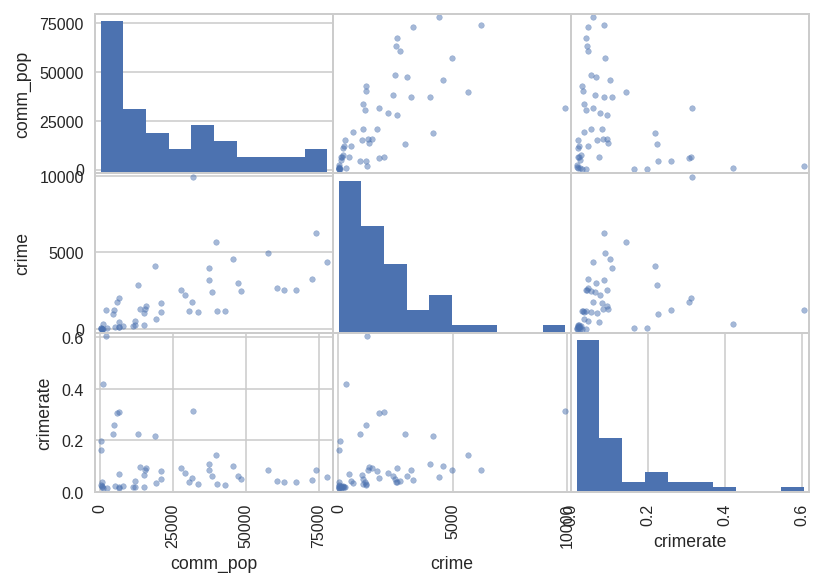

In [5]:
# plot a scatter matrix of the crime ratios 
fig = pd.scatter_matrix(df_stats)

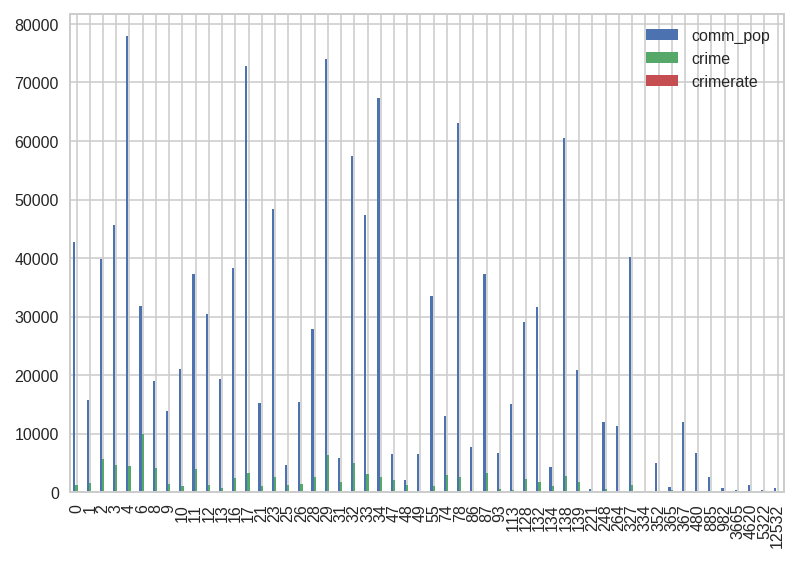

In [6]:
# plot the ratios of crime rate to population per community
df_stats.plot(kind="bar")

In [7]:
# histogram plot of population to number of crime incidents
pairplots = sns.pairplot(df_stats)
pairplots.set(xticklabels=[])

In [8]:
# plot the community populations to respective crime incidents counts


In [9]:
# plot of incidents counts by community (bar chart)
counts_by_community.plot(kind="bar")
f1 = plt.show()
f1 = plt.gcf()

In [10]:
# plot of incident counts by community (histogram)
counts_by_community.plot(kind="hist")
f2 = plt.show()
f2 = plt.gcf()

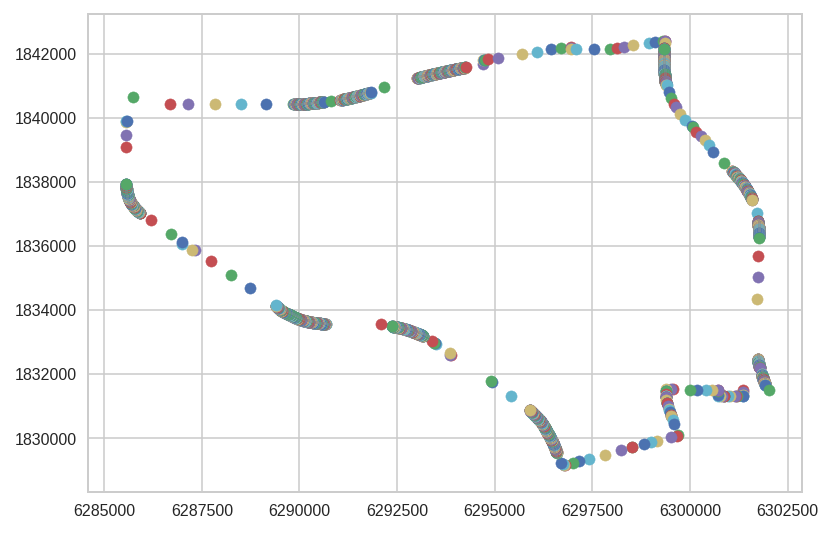

In [11]:
# working with shapefiles inspired by our dear Voyteck's geospatial tutorial
import shapefile

read_shapefile = shapefile.Reader("COMMUNITY_PLAN_SD.shp")
shapes = read_shapefile.shapes()


read_shapemeta = shapefile.Reader("COMMUNITY_PLAN_SD.dbf")
shapemeta = read_shapemeta.shapeRecords()
# dir(read_shapemeta)

# for i in range(len(shapemeta)):
#     print(shapemeta[i].record)

# for i in range(len(shapes)):
#     print(shapes[i].points)

    
# this is what SD community points look like as a scatterplot
j = 0
for i in range(len(shapes[j].points)):
    plt.scatter(shapes[j].points[i][0], shapes[j].points[i][1])

plt.show()

In [12]:
comm_shapes = []

for i in range(len(shapes)):
    comm_shapes.append(shapes[i].points)
    

In [13]:
SD_LAT_LONG = (32.7157, -117.1611)

communities_map = folium.Map(location=SD_LAT_LONG, zoom_start=12, tiles='Stamen Toner')

for i in range(len(comm_shapes)):
    comm_line = folium.PolyLine(locations=comm_shapes[i], weight=2, color='blue')
    communities_map.add_child(comm_line)
    
communities_map    

In [14]:
# converted the "incidents-100k.csv" dataset into a geojson file using
# convertcsv.com webclient

# SD_LONG_LAT = (32.7157, 117.1611)
# community_geography = r'incidents-geo.geojson'

# crime_by_comm = pd.DataFrame(df['community'].value_counts())
# crime_by_comm.to_json('crime_counts.json')
# crime_by_comm = crime_by_comm.reset_index()
# print(crime_by_comm)

# creation of the choropleth CRIME INCIDENTS




# folium.Map(PolyColor)
# choro_crime_comm = folium.Map(location=SD_LONG_LAT, zoom_start=10)
# choro_crime_comm.geo_json(geo_path = community_geography, data_out = 'crime_counts.json',
#                           data = crime_by_comm, columns = ['community', 'number'], 
#                           key_on = 'feature.properties.COMMUNITY', fill_color = 'YlOrRd', 
#                           fill_opacity = 0.7, line_opacity = 0.2, 
#                           legend_name = 'Number of incidents per Community')
# display(choro_crime_comm)

# plot correlation of rate of particular crime to number of ABC licenses (where each point is a community) 

In [15]:
# 2012 length --> 143182 for incidents 57
# 2012 length --> 13923 for incidents-100k.csv
# df_2012=df.loc[df['year']== 2012]
# df_2012['type'].value_counts()
# j = 0
# points = []
# for i in range (1000):
#    latitude = df['lat'][j]
#    longitude = df['lon'][j]
#    points.append(tuple([latitude,longitude]))
#    j = j + 1
#    g = geocoder.google([latitude, longitude], method='reverse')
#    if (g.state != 'CA'):
#        pass
#    else:     

In [16]:
# df['lat']
csv_file = 'abc_licenses_sdcounty.csv'
df2 = pd.read_csv(csv_file)

In [17]:
# points2 = []
# j=0
# for i in range (1000):
#     latitude = df2['lat'][j]
#     longitude = df2['lon'][j]
#     points2.append(tuple([latitude,longitude]))
#     j = j + 1
#     #g = geocoder.google([latitude, longitude], method='reverse')
#     #if (g.state!='CA'):
#     #    pass
#     #else:
    

In [18]:
# j = 0
# lat = 0
# lon = 0
# zoom_start=2
# m = folium.Map(location=[lat, lon], zoom_start=zoom_start)
# if (len(points)<(len(points2))):
#    length=(len(points))
# else:
#    length=(len(points2))
# for i in range(length):
#    coord_1 = points[j]
#    coord_2 = points2[j]
#    kw = dict(fill_color='red', radius=5)
#    kw2 = dict(fill_color='blue' ,radius=4)
#    c0 = folium.CircleMarker(coord_1, **kw)
#    c1 = folium.CircleMarker(coord_2, **kw2)
#    for c in [c0,c1]:
#        m.add_child(c)
#    j = j + 1

# folium.PolyLine(points, color="yellow", weight=1.5, opacity=1).add_to(m)
# m

In [19]:
# building a choropleth map from our incidents-100k.csv dataset
# converted from csv to geojson format using the ogr2ogr web client, ogre.acd4gis.com 
# (too resource costly for notebook to handle)

# using the aggregate 2012 incidents shapefile to establish map boundaries 
# http://geospatialpython.com/2013/07/shapefile-to-geojson.html
# read in the shapefile using shapefile.Reader

# read_shp = shapefile.Reader("crime-incidents-2012.shp")
# shp_fields = read_shp.fields[1:]
# field_names = [field[0] for field in shp_fields]
# processShape = []
# for shape_records in read_shp.shapeRecords():
#        atr = dict(zip(shp_fields, shape_records.record))
#        geom = shape_records.shape.__geo_interface__
#        processShape.append(dict(type="Feature", geometry=geom, properties=atr)) 
   
# # write the GeoJSON file
# from json import dumps
# geojson = open("pyshp-demo.json", "w")
# geojson.write(dumps({"type": "FeatureCollection", "features": processShape}, indent=2) + "\n")
# geojson.close()